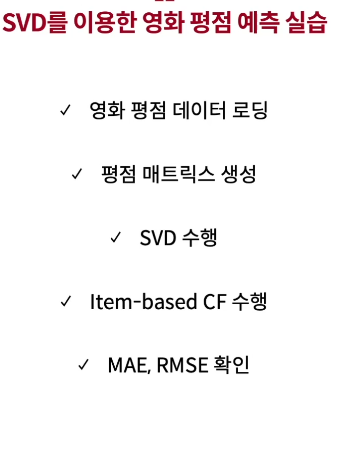

# Matrix Factorization: SVD

In [ ]:
%run liblecture.py

from numpy import linalg as LA
from scipy.sparse import coo_matrix
from scipy.linalg import sqrtm


## Read Data: movies and ratings
Read Movies and Define displayMovies

In [ ]:
movies = pd.read_csv('movielens/movies_w_imgurl.csv')
movies

,movieId,imdbId,title,genres,imgurl
0,1,114709,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,https://images-na.ssl-images-amazon.com/images...
1,2,113497,Jumanji (1995),Adventure|Children|Fantasy,https://images-na.ssl-images-amazon.com/images...
2,3,113228,Grumpier Old Men (1995),Comedy|Romance,https://images-na.ssl-images-amazon.com/images...
3,4,114885,Waiting to Exhale (1995),Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
4,5,113041,Father of the Bride Part II (1995),Comedy,https://images-na.ssl-images-amazon.com/images...
...,...,...,...,...,...
9120,162672,3859980,Mohenjo Daro (2016),Adventure|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
9121,163056,4262980,Shin Godzilla (2016),Action|Adventure|Fantasy|Sci-Fi,https://images-na.ssl-images-amazon.com/images...
9122,163949,2531318,The Beatles: Eight Days a Week - The Touring Y...,Documentary,https://images-na.ssl-images-amazon.com/images...
9123,164977,27660,The Gay Desperado (1936),Comedy,https://images-na.ssl-images-amazon.com/images...


Read Rating Data

In [ ]:
ratings = pd.read_csv('ratings-9_1.csv')

train = ratings[ratings['type'] == 'train'][['userId', 'movieId', 'rating']]
test = ratings[ratings['type'] == 'test'][['userId', 'movieId', 'rating']]

## Convert Ratings to User-Item Sparse Matrix
### Create Index to Id Maps

In [ ]:
movieIds = train.movieId.unique()

movieIdToIndex = {}
indexToMovieId = {}

colIdx = 0

for movieId in movieIds:
    movieIdToIndex[movieId] = colIdx
    indexToMovieId[colIdx] = movieId
    colIdx += 1

In [ ]:
userIds = train.userId.unique()

userIdToIndex = {}
indexToUserId = {}

rowIdx = 0

for userId in userIds:
    userIdToIndex[userId] = rowIdx
    indexToUserId[rowIdx] = userId
    rowIdx += 1

### Creat User-Item Sparse Matrix

In [ ]:
rows = []
cols = []
vals = []

for row in train.itertuples():
    rows.append(userIdToIndex[row.userId])
    cols.append(movieIdToIndex[row.movieId])
    vals.append(row.rating)

coomat = coo_matrix((vals, (rows, cols)), shape=(rowIdx, colIdx))

matrix = coomat.todense()
matrix.shape

(671, 8740)

## Sigular Value Decomposition

In [ ]:
U, s, V = LA.svd(coomat.toarray(), full_matrices = False)
U

array([[-1.90e-03,  3.32e-03,  1.20e-03, ..., -9.40e-03,  4.95e-03,
        -7.56e-03],
       [-1.83e-02,  7.45e-03, -6.44e-02, ..., -8.41e-03, -3.24e-02,
        -6.83e-03],
       [-1.53e-02, -1.30e-02, -1.21e-02, ..., -1.20e-02, -3.64e-04,
        -4.68e-03],
       ...,
       [-7.76e-03,  1.79e-03, -2.03e-05, ..., -4.11e-03,  3.37e-04,
        -4.23e-03],
       [-1.09e-02,  1.94e-04, -1.21e-02, ...,  3.30e-02, -7.91e-04,
        -4.25e-03],
       [-3.81e-02, -1.99e-02,  9.78e-04, ..., -4.82e-03, -1.25e-03,
        -3.43e-03]])

### Define user and item feautre matrix

In [ ]:
dim = 100
sqrtS = sqrtm(np.diag(s[0:dim]))

In [ ]:
userFeatures = np.matmul(U.compress(np.ones(dim), axis=1), sqrtS)
itemFeatures = np.matmul(V.T.compress(np.ones(dim), axis=1), sqrtS.T)

In [ ]:
itemFeatures.shape

(8740, 100)

### Compute item similarity matrixes

In [ ]:
itemNorms = LA.norm(itemFeatures, ord = 2, axis=1)
normalizedItemFeatures = np.divide(itemFeatures.T, itemNorms).T
itemSims = pd.DataFrame(data = np.matmul(normalizedItemFeatures, normalizedItemFeatures.T), index = movieIds, columns=movieIds)
itemSims

,31,1061,1129,1172,1287,1293,1339,1343,1371,1405,...,134528,134783,137595,138204,60832,64997,72380,129,4736,6425
31,1.00,0.11,1.09e-02,-1.65e-01,0.10,0.12,-0.13,0.12,3.42e-02,0.10,...,-0.19,-0.19,-0.19,-0.19,-8.51e-02,-8.51e-02,-8.51e-02,-1.04e-02,-1.04e-02,-0.12
1061,0.11,1.00,1.85e-01,1.61e-01,0.05,-0.04,0.16,0.04,-1.37e-02,0.14,...,0.02,0.02,0.02,0.02,-4.28e-02,-4.28e-02,-4.28e-02,2.17e-01,2.17e-01,-0.03
1129,0.01,0.18,1.00e+00,7.19e-02,0.15,-0.07,0.18,0.25,2.28e-01,0.19,...,0.04,0.04,0.04,0.04,-9.18e-02,-9.18e-02,-9.18e-02,-6.75e-03,-6.75e-03,-0.03
1172,-0.16,0.16,7.19e-02,1.00e+00,0.19,0.19,-0.06,-0.02,-3.12e-02,0.05,...,-0.02,-0.02,-0.02,-0.02,-9.05e-03,-9.05e-03,-9.05e-03,-4.55e-02,-4.55e-02,0.04
1287,0.10,0.05,1.53e-01,1.93e-01,1.00,0.25,0.02,-0.13,9.94e-03,0.09,...,-0.09,-0.09,-0.09,-0.09,1.07e-02,1.07e-02,1.07e-02,1.27e-02,1.27e-02,-0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64997,-0.09,-0.04,-9.18e-02,-9.05e-03,0.01,-0.05,0.29,-0.04,-6.00e-02,0.13,...,-0.06,-0.06,-0.06,-0.06,1.00e+00,1.00e+00,1.00e+00,2.00e-02,2.00e-02,0.03
72380,-0.09,-0.04,-9.18e-02,-9.05e-03,0.01,-0.05,0.29,-0.04,-6.00e-02,0.13,...,-0.06,-0.06,-0.06,-0.06,1.00e+00,1.00e+00,1.00e+00,2.00e-02,2.00e-02,0.03
129,-0.01,0.22,-6.75e-03,-4.55e-02,0.01,-0.06,0.18,-0.08,-5.98e-02,-0.07,...,-0.08,-0.08,-0.08,-0.08,2.00e-02,2.00e-02,2.00e-02,1.00e+00,1.00e+00,-0.02
4736,-0.01,0.22,-6.75e-03,-4.55e-02,0.01,-0.06,0.18,-0.08,-5.98e-02,-0.07,...,-0.08,-0.08,-0.08,-0.08,2.00e-02,2.00e-02,2.00e-02,1.00e+00,1.00e+00,-0.02


### Check Example 

In [ ]:
movieIdx = 6

rels = itemSims.iloc[movieIdx,:].sort_values(ascending=False).head(6)[1:]

displayMovies(movies, [indexToMovieId[movieIdx]])
displayMovies(movies, rels.index, rels.values)

## User Rating Prediction

In [ ]:
userId = 33

userRatings = train[train['userId'] == userId][['movieId', 'rating']] 

userRatings

,movieId,rating
6176,19,3.0
6177,88,3.0
6178,157,1.0
6179,231,3.0
6180,344,4.0
...,...,...
6309,5282,4.0
6310,5339,4.0
6311,5483,4.0
6312,5669,4.0


### Predict Ratings

In [ ]:
recSimSums = itemSims.loc[userRatings['movieId'].values, :].sum().values

recWeightedRatingSums = np.matmul(itemSims.loc[userRatings['movieId'].values, :].T.values, userRatings['rating'].values)

recItemRatings = pd.DataFrame(data = np.divide(recWeightedRatingSums, recSimSums), index=itemSims.index)

recItemRatings.columns = ['pred']

recItemRatings

,pred
31,3.51
1061,3.53
1129,3.44
1172,3.81
1287,4.07
...,...
64997,2.97
72380,2.97
129,6.52
4736,6.52


### Compute Errors (MAE, RMSE)

In [ ]:
userTestRatings = pd.DataFrame(data=test[test['userId'] == userId])

temp = userTestRatings.join(recItemRatings.loc[userTestRatings['movieId']], on='movieId')

mae = getMAE(temp['rating'], temp['pred'])
rmse = getRMSE(temp['rating'], temp['pred'])

print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

MAE : 0.7069
RMSE: 0.8262


### Compare Logs and Recommendations

In [ ]:
logs = userRatings.sort_values(by='rating', ascending=False).head(20)
recs = recItemRatings.sort_values(by='pred', ascending=False).head(20)

print("logs")
displayMovies(movies, logs['movieId'].values, logs['rating'].values)

print("recs")
displayMovies(movies, recs.index, recs['pred'].values)

logs


recs
